# <center>Decision Trees</center>
---

**Decision Trees (DTs)** are a **non-parametric** supervised learning method used for classification and regression, and even for multi-output tasks. They are powerful algorithms, capable of fitting complex datasets. The **<font color='crimson'>goal</font>** is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [1]:
# Common imports
import os
import sys
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

In [2]:
print('python version:', sys.version_info)
print('matplotlib version:', mpl.__version__)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)

python version: sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib version: 3.1.2
numpy version: 1.18.1
pandas version: 1.0.1
scikit-learn version: 0.22.1


## 1. Train and visualize a decision tree

In [3]:
# Load Iris dataset
from sklearn.datasets import load_iris

iris = load_iris()

In [4]:
iris.feature_names  # 花萼、花瓣

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [6]:
x = iris.data[:, 2:]  # petal length and width
y = iris.target

x.shape, y.shape

((150, 2), (150,))

In [7]:
# Train a decision tree and use it to make predictions
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(x, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

`DecisionTreeClassifier` is capable of both binary classification and multi-class classification.

**<font color='crimson'>Visualize the trained DT 1:</font>**

**`sklear.tree.plot_tree`** plots a decision tree. (The visualization is fit automatically to the size of the axis. Use the `figsize` or `dpi` arguments of `plt.figure` to control the size of the rendering.)

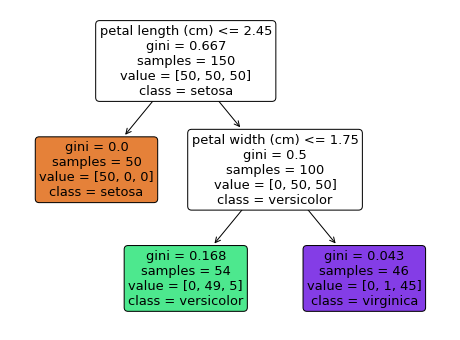

In [8]:
# Plot the tree with the `plot_tree`
from sklearn.tree import plot_tree

plt.figure(figsize=(8, 6))
plot_tree(tree_clf,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names,
          filled=True,
          rounded=True)
plt.show()

**<font color='crimson'>Visualize the trained DT 2:</font>**

**`sklearn.tree.export_graphviz`** exports a decision tree in DOT format. It generates a GraphViz representation of the decision tree, which is written into `out_file`. Once exported, graphical renderings can be generated using:
  ```bash
  # Convert the DOT file to a variety of formats, like:
  $ dot -Tps tree.dot -o tree.ps      # PostScript format
  $ dot -Tpng tree.dot -o tree.png    # PNG format
  ```

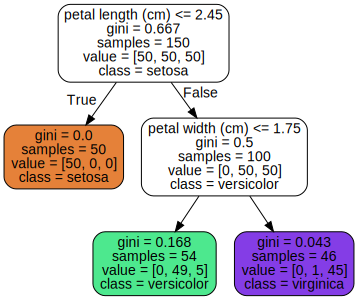

In [9]:
import graphviz

from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_clf,
                           out_file=None,  # the result is returned as a string
                           feature_names=iris.feature_names[2:],
                           class_names=iris.target_names,
                           filled=True,
                           rounded=True)
graph = graphviz.Source(dot_data)
# graph = graphviz.Source.from_file(output_file)  # if out_file='xxx/xx/x.dot'
graph

**<font color='crimson'>Visualize the trained DT 3:</font>**

**`sklearn.tree.export_text`** builds a text report showing the rules of a decision tree.

In [10]:
from sklearn.tree import export_text

# Text summary of all the rules in the decision tree
report = export_text(tree_clf, feature_names=iris.feature_names[2:])
print(report)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- class: 1
|   |--- petal width (cm) >  1.75
|   |   |--- class: 2



## 2. Make predictions

**<font color='blue'>Process:</font>**

You start at the *root node* (depth 0, at the top): this node asks whether the flower's petal length is smaller than 2.45 cm.
  - If it is, then you move down to the root's left child node (depth 1, left). In this instance, it's a *leaf node* (i.e., it doesn't have any child nodes), so it does not ask any questions: simply look at the predicted class for that node (here is "setosa").


  - If it's not, then you move down to the root's right child node (depth 1, right), which is not a leaf node, so the node asks another question: is the petal width smaller than 1.75 cm?
    - If it is, then your flower is most likely a "versicolor" (depth 2, left);
    - If not, it's likely a "virginica".

**<font color='blue'>Node's attribute:</font>**

- **`samples`**: counts how many training instances it applies to.
  > E.g., in the (depth 1, right) node, 100 training instances have a petal length greater than 2.45 cm, and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left).


- **`value`**: tells you how many training instances of each class this node applies to.
  > E.g., the bottom right node (depth 2, right) applies to 0 "setosa", 1 "versicolor", and 45 "virginica".


- **`gini`**: measures its impurity: a node is "pure" ($gini=0$) if all training instances it applies to belong to the same class.
  > E.g., the (depth 1, left) node applies only to "setosa" training instances, it's pure and its `gini` score is 0.

**<font color='red' size=3>Gini impurity:</font>**

In classification task, there are k classes, and the probability that a instance belongs to the $k^{th}$ class is $p_k$, so

$$Gini(p)=\sum^k_{k=1}p_k(1-p_k)=1-\sum^n_{k=1}p_{i, k}^2$$

> E.g., the (depth 2, left) node has a gini score equal to $1-(0/54)^2-(49/54)^2-(5/54)^2\approx 0.168.$

In [11]:
from matplotlib.colors import ListedColormap

In [12]:
def plot_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    X_new = np.c_[xx.ravel(), yy.ravel()]
    y_pred = clf.predict(X_new).reshape(xx.shape)

    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(xx, yy, y_pred, alpha=0.3, cmap=custom_cmap)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo', label=iris.target_names[0])
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', label=iris.target_names[1])
    plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], 'g^', label=iris.target_names[2])

    plt.xlabel('Petal length (cm)', fontsize=14)
    plt.ylabel('Petal width (cm)', fontsize=14)
    plt.legend(fontsize=14)

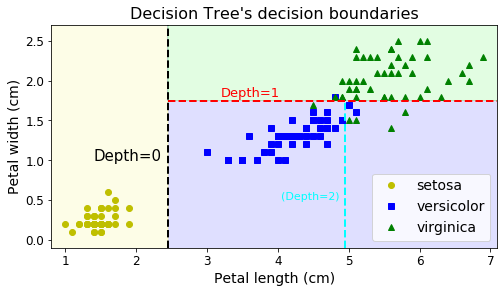

In [13]:
plt.figure(figsize=(8, 4.1))
plot_decision_boundary(tree_clf, x, y)
plt.title("Decision Tree's decision boundaries", fontsize=16)

plt.plot([2.45, 2.45], [x[:, 1].min()-0.2, x[:, 1].max()+0.2], 'k--', linewidth=2)
plt.plot([2.45, x[:, 0].max()+0.2], [1.75, 1.75], 'r--', linewidth=2)
plt.plot([4.95, 4.95], [x[:, 1].min()-0.2, 1.75], c='Cyan', ls='--', lw=2)
plt.text(1.40, 1.0, 'Depth=0', color='k', fontsize=15)
plt.text(3.2, 1.80, 'Depth=1', color='r', fontsize=13)
plt.text(4.05, 0.5, '(Depth=2)', color='Cyan', fontsize=11)

plt.show()

> The **black dashed line** represents the decision boundary of the root node (depth 0): pental length=2.45 cm. Since the lefthand area is pure (only "setosa"), it cannot be split any further. However, the righthand area is impure, so the (depth 1, right) node splits at the width=1.75 cm (represented by the **red dashed line**). Since the `max_depth` was set to 2, the DT stops right here. If you set `max_depth` to 3, then the two depth-2 nodes would each add another decision boundary (represented by the **cyan dashed line).

**<font color='crimson' size=3>DTs require very little data preparation. In fact, they do not require feature scaling or centering at all.</font>**

## 3. Estimate class probabilities

**<font color='blue'>Process:</font>**

- 1st, traverse the tree to find the leaf node for this instance;


- 2nd, return the ratio of training instances of class k in this node.

> E.g., instance `(5, 1.5)`. The corresponding leaf node is the (depth 2, left) node, so the DT should output the probabilities: 0% (0/54) for "setosa", 90.7% (49/54) for "versicolor", and 9.3% (5/54) for "virginica". 

In [14]:
# The probability of each class can be predicted,
# which is the fraction of training instances of the same class in a leaf node:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [15]:
# Predict the class of samples
tree_clf.predict([[5, 1.5]])

array([1])

## 4. The CART algorithm

**<font color='blue'>Scikit-Learn uses the Classification and Regression Tree (CART) algorithm</font>**, which <font color='blue'>produces only binary trees: non-leaf nodes always have two children</font> (i.e, questions only have yes/no answers). However, other algorithms such as **ID3 can produce DTs with nodes that have more than 2 children**.

**<font color='crimson'>The DTs trained by the CART are called "growing" trees.</font>**

**<font color='blue'>Process:</font>**

**<font color='blue'>- 1st:</font>** the CART splits the training set into two subsets using a single featue k and a threshold t (e.g., "petal length ≤ 2.45 cm"). It searches for the pair (k, t) that produces the purest subsets (weighted by their size). The cost function that the CART tries to minimize is

$$J(k, t)=\frac{m_{left}}{m}G_{left}+\frac{m_{right}}{m}G_{right}$$

> $G_{left/right}$ measures the impurity of the left/right subset,
$m_{left/right}$ is the number of instances in the left/right subset


- If a target is a **classification**, the common measure of impurity are: ($X_m$ is the training data in node m)
       
      GINI

$$G(X_m)=\sum^k_{k=1}p_k(1-p_k)=1-\sum^n_{k=1}p_{i, k}^2$$

       Entropy
$$G(X_m)=-\sum^k_{k=1}p_{i, k}log(p_{i, k})$$

       and Misclassification
$$G(X_m)=1-max(p_{i, k})$$

- If it's a **regression** task, common criteria to minimise as for determining locations for future splits are MSE and MAE. ($X_m$ is the training data in node m, $N_m$ is the number of training data in node m.)

$$\hat y_m =\frac{1}{N_m}\sum_{i\in N_m}y_i$$

       MSE
$$G(X_m) = \frac{1}{N_m}\sum_{i\in N_m}(y_i-\hat y_m)^2$$

       MAE
$$G(X_m) = \frac{1}{N_m}\sum_{i\in N_m}|y_i-\hat y_m|$$

<br>

**<font color='blue'>- 2nd:</font>** the CART splits the subsets using the same logic


**<font color='blue'>- 3rd:</font>** the sub-subsets


**<font color='blue'>...</font>**

**<font color='blue'>- stop</font>** It **stops** recursing once it reaches the maximum depth (defined by the `max_depth`), or if it cannot find a split that will reduce impurity. `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, and `max_leaf_nodes` can also control stopping conditions.

<div class="alert alert-block alert alert-block alert-info">
The CART is a <b>greedy algorithm</b>: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It <b>does not check whether or not the split will lead to the lowest possible impurity several levels down</b>. A greedy algorithm <b>often produces a solution that's reasonably good but not guaranteed to be optimal</b>.
    
Unfortunately, finding the optimal tree is known to be an NP-Complete problem: it requires $O(exp(m))$ time, making the problem intractable even for small training sets. This is why we must settle for a “reasonably good” solution.
</div>

## 5. Gini impurity or Entropy ?

The default of `criterion` is `'gini'`, but you can use `'entropy'`.

> The concept of entropy originated (起源) in thermodynamics (热力学) as a measure of molecular disorder (分子间的无序性): **entropy approaches zero when molecules are still and well ordered**. Entropy later spread to a wide variety of domains, including <font color='red'>Shannon’s information theory</font>, where it **measures the average information content of a message: entropy is zero when all messages are identical**.

<font color='crimson'>In ML, entropy is often used as an impurity measure: a set's entropy is 0 when it contains instances of only one class.</font>

<br>

**<font color='red' size=3>Entropy:</font>**

$$H=-\sum^n_{k=1}p_{i, k}log(p_{i, k})$$

<br>

<div class="alert alert-block alert alert-block alert-info">

Most of the time, it does not make a big difference: they <b>lead to a similar trees</b>. <b>Gini impurity is slightly faster to compute, so it's a good default</b>. However, <b>when they differ</b>, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced treee.

</div>

## 6. Computational complexity

**<font color='crimson'>Prediction:</font>**

> It requires traversing the DT from the root to a leaf. **DT generally are approximately balanced**, so traversing the DT requires going through roughly $O(log_2(m))$ nodes. Since each node only requires checking the value of one feature, the **overall prediction complexity is $O(log_2(m))$, independent of the number of features**. So predictions are **very fast, even when dealing with large training sets**.


**<font color='crimson'>Training:</font>**

> It compares all features (or less if `max_features` is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of $O(nmlog_2(m))$. **For small training sets** (less than a few thousand instances), sklearn **can speed up training by presorting the data** (set `presort=True`), but doing **that slows down training considerably for larger training sets**.

## 7. Regularization hyperparameters

Decision Trees <font color='blue'>make very few assumptions about the training data</font> (as opposed to linear models, which assume that the data is linear, for example).


<font color='blue'>If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely</font> (indeed, most likely overfitting it). Such a model is often called a **<font color='red'>nonparametric model</font>**, not because **it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data**. In contrast, a **<font color='red'>parametric model</font>**, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting, you need to restrict the DT freedom during training. This is called regularization. The regularization hyperparameters depend on the algorithm used.

- **`max_depth`** (default `None` means unlimited): restrict the maximum depth of the DT.


- **`max_leaf_nodes`** (default `None` means unlimited): the maximum number of leaf nodes.


- **`max_features`** (default `None` means using all features): the number of features to consider when looking for the best split.
  - int: consider `max_features` features at each split;
  - float: then max_features is a fraction and int(max_features * n_features) features are considered at each split;
  - `'auto'`: `max_features=sqrt(n_features)`
  - `'sqrt'`: `max_features=sqrt(n_features)`
  - `'log2'`: `max_features=log2(n_features)`
  - `None`: `max_features=n_features`
  
  
- **`min_samples_split`** (default=2): the minimum number of samples a node must have before it can be split
  - int, consider min_samples_split as the minimum number
  - float, `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split.


- **`min_samples_leaf`** (default=1): the minimum number of samples a leaf node must have
  - int
  - float


- **`min_weight_fraction_leaf`** (default=0.0): (same as `min_samples_leaf`) the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

<br>

**<font color='crimson'>Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.</font>**

<div class="alert alert-block alert alert-block alert-info">
    
Other algorithms work by first training the Decision Tree without restrictions, then pruning (deleting) unnecessary nodes. <b>A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant</b>. Standard statistical tests, such as the χ2 test (chi-squared test), are used to estimate the probability that the improvement is purely the result of chance (which is called the null hypothesis). If this probability, called the p-value, is higher than a given threshold (typically 5%, controlled by a hyperparameter), then the node is considered unnecessary and its children are deleted. The pruning continues until all unnecessary nodes have been pruned.
</div>

In [16]:
def plot_decision_boundary_2(clf, X, y):
    x_min, x_max = X[:, 0].min()-0.2, X[:, 0].max()+0.2
    y_min, y_max = X[:, 1].min()-0.2, X[:, 1].max()+0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    X_new = np.c_[xx.ravel(), yy.ravel()]
    y_pred = clf.predict(X_new).reshape(xx.shape)

    custom_cmap = ListedColormap(['#fafab0', '#a0faa0'])
    plt.contourf(xx, yy, y_pred, alpha=0.3, cmap=custom_cmap)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo')
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'g^')

    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14)

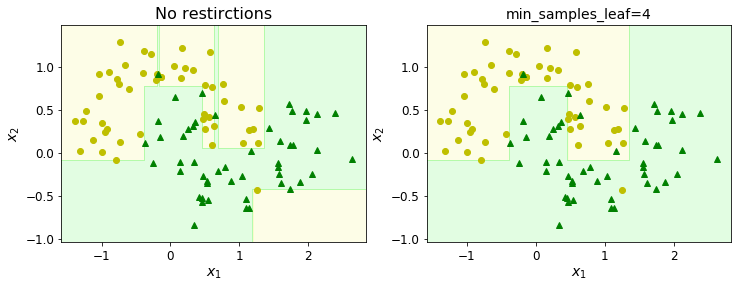

In [17]:
from sklearn.datasets import make_moons

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

# No restrictions
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf1.fit(Xm, ym)
# A leaf node must have 4 instances
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf2.fit(Xm, ym)

# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_decision_boundary_2(deep_tree_clf1, Xm, ym)
plt.title("No restirctions", fontsize=16)

plt.subplot(122)
plot_decision_boundary_2(deep_tree_clf2, Xm, ym)
plt.title("min_samples_leaf=4", fontsize=14)
plt.show()

It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.

## 8. Instability

- **<font color='crimson'>DTs love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation.</font>**

**<font color='blue'>One way to limit this problem is to use PCA, which often results in a better orientation (方向) of the training data.</font>**

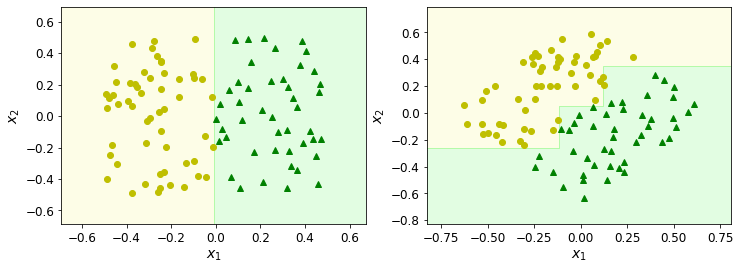

In [18]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32)

# Rotate the dataset by 45°
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

# Train DTs
tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_decision_boundary_2(tree_clf_s, Xs, ys)

plt.subplot(122)
plot_decision_boundary_2(tree_clf_sr, Xsr, ys)

plt.show()

On the left, a DT can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundaries looks unnecessarily convoluted (复杂的). Although both Decision Trees fit the training set perfectly, it is very likely that the model on the right will not generalize well.

- **<font color='crimson'>The main issue with DTs is that they are very sensitive to small variations in the training data.</font>**

> E.g., after you remove the widest "Iris versicolor" from the iris training set, you may get a model different from the previous DT.

Actually, since <font color='crimson'>the training algorithm used by Scikit-Learn is stochastic (It randomly selects the set of features to evaluate at each node.), you may get very different models even on the same training data</font> (unless you set the `random_state` hyperparameter).

**<font color='blue'>Random Forests can limit this instability by averaging predictions over many trees.</font>**

In [19]:
# widest Iris versicolor flower
x_widest_versicolor = x[(x[:, 1] == x[:, 1][y == 1].max()) & (y == 1)]
x_widest_versicolor

array([[4.8, 1.8]])

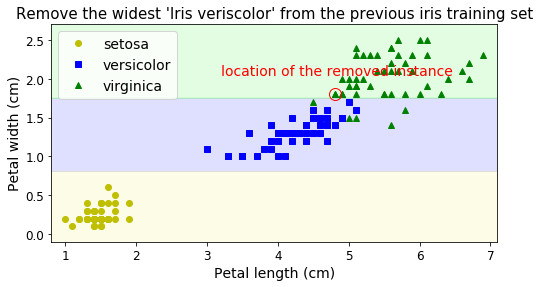

In [20]:
not_widest_versicolor = (x[:, 1]!=1.8) | (y==2)
x_tweaked = x[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(x_tweaked, y_tweaked)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, x_tweaked, y_tweaked)
plt.plot(x_widest_versicolor[:, 0], x_widest_versicolor[:, 1],
         marker='o', markerfacecolor='none', markeredgecolor='r', markersize=12)
plt.text(3.2, 2.05, "location of the removed instance", color='r', fontsize=14)
plt.title("Remove the widest 'Iris veriscolor' from the "
          "previous iris training set", fontsize=15)
plt.show()

## 9. Regression

In [21]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
x = np.random.rand(m, 1)
y = 4 * (x - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

x.shape, y.shape

((200, 1), (200, 1))

In [22]:
# Train a DT regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(x, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

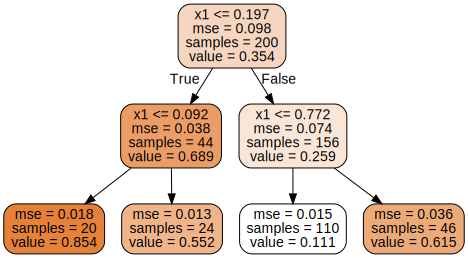

In [23]:
dot_data = export_graphviz(
    tree_reg,
    out_file=None,  # the result is returned as a string
    feature_names=['x1'],
    filled=True,
    rounded=True)
graph = graphviz.Source(dot_data)
# graph = graphviz.Source.from_file(output_file)  # if out_file='xxx/xx/x.dot'
graph

The prediction is always the average value of the training instances associated with this leaf node.

In [24]:
def plot_regression_predictions(tree_reg, X, y):
    X_new = np.linspace(X.min()-0.2, X.max()+0.2, 1000).reshape(-1, 1)
    y_pred_new = tree_reg.predict(X_new)

    plt.plot(X, y, 'b.')
    plt.plot(X_new, y_pred_new, 'r.-', lw=2, label='$\hat{y}$')
    plt.legend(fontsize=16)
    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$y$', fontsize=16)

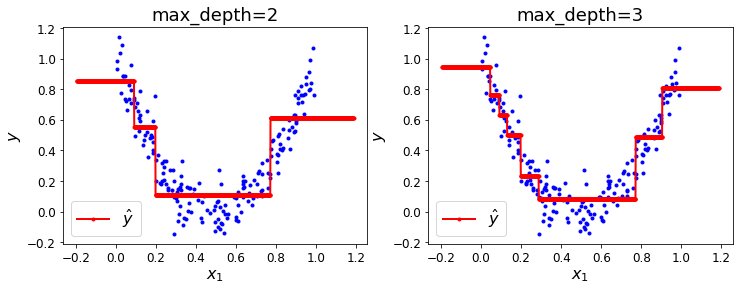

In [25]:
tree_reg_1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg_1.fit(x, y)
tree_reg_2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg_2.fit(x, y)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg_1, x, y)
plt.title("max_depth=2", fontsize=18)

plt.subplot(122)
plot_regression_predictions(tree_reg_2, x, y)
plt.title("max_depth=3", fontsize=18)

plt.show()

**Just like for classification tasks, DTs are prone to overfitting when dealing with regression tasks.**

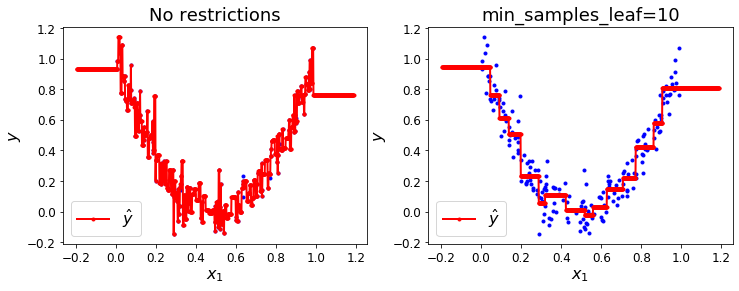

In [26]:
# Train a DT regressor without restrictions
tree_reg_1 = DecisionTreeRegressor(random_state=42)
tree_reg_1.fit(x, y)
# Train a DT regressor with `min_samples_leaf` set to 10
tree_reg_2 = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
tree_reg_2.fit(x, y)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg_1, x, y)
plt.title("No restrictions", fontsize=18)

plt.subplot(122)
plot_regression_predictions(tree_reg_2, x, y)
plt.title("min_samples_leaf=10", fontsize=18)

plt.show()

## 10. Multi-output problems

A multi-output problem is a supervised learning problem with several outputs to predict, that is when Y is a 2d array of size **`[n_samples, n_outputs]`**.

**<font color='crimson'>It is likely the output values related to same input are themselves correlated, and often better way is to build a single model capable of predicting simultaneously all n outputs.</font>**

- It requires lower training times since only a single estimator is built.


- The generalization accuracy of the resulting estimator may often be increased.

**With regard to DTs, this strategy can readily be used to support multi-output problems**. This requires the following changes:

1. Store n output values in leaves, instead of 1;
2. Use splitting criteria that compute the average reduction across all n outputs.

`DecisionTreeClassifier` and `DecisionTreeRegressor` both support this strategy. If a DT is fit on an output array Y of size `[n_samples, n_outputs]`, then thee resulting estimator will:
1. Output `n_outputs` values upon `predict`;
2. Output a list of `n_outputs` arrays of class probabilities upon `predict_proba`.

- **<font color='blueviolet'>Multi-output DT regression</font>**

In [27]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(200 * rng.rand(100, 1) - 100, axis=0)
y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
y[::5, :] += (0.5 - rng.rand(20, 2))

X.shape, y.shape

((100, 1), (100, 2))

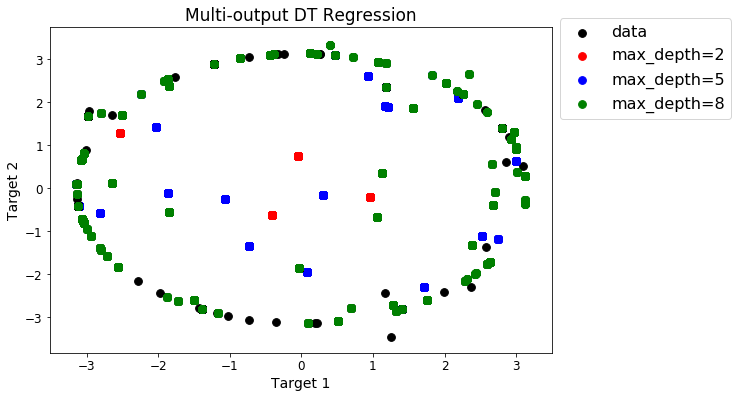

In [28]:
# Fit DT regression model
tree_reg_1 = DecisionTreeRegressor(max_depth=2, random_state=rng)
tree_reg_1.fit(X, y)
tree_reg_2 = DecisionTreeRegressor(max_depth=5, random_state=rng)
tree_reg_2.fit(X, y)
tree_reg_3 = DecisionTreeRegressor(max_depth=8, random_state=rng)
tree_reg_3.fit(X, y)

# Predict
# or .reshape(-1, 1)
X_test = np.arange(-100., 100, 0.01)[:, np.newaxis]
y_pred_1 = tree_reg_1.predict(X_test)
y_pred_2 = tree_reg_2.predict(X_test)
y_pred_3 = tree_reg_3.predict(X_test)

# Plot the results
plt.figure(figsize=(9, 6))
s = 60
plt.scatter(y[:, 0], y[:, 1], c='k', s=s, edgecolor='k', label='data')
plt.scatter(y_pred_1[:, 0], y_pred_1[:, 1], c='r', s=s, edgecolor='r',
            label='max_depth=2')
plt.scatter(y_pred_2[:, 0], y_pred_2[:, 1], c='b', s=s, edgecolor='b',
            label='max_depth=5')
plt.scatter(y_pred_3[:, 0], y_pred_3[:, 1], c='g', s=s, edgecolor='g',
            label='max_depth=8')
plt.legend(bbox_to_anchor=(1.0, 1.05), fontsize=16)
plt.xlabel('Target 1', fontsize=14)
plt.ylabel('Target 2', fontsize=14)
plt.title("Multi-output DT Regression", fontsize=17)
plt.show()

- **<font color='blueviolet'>Multi-output DT classification</font>**

This example shows the use of multi-output estimator to complete images. The goal is to predict the lower half of a face given its upper half. (The inputs `X` are the pixels of the upper half of faces and the outputs `Y` are the pixels of the lower half of those faces.)

[Here](https://scikit-learn.org/stable/auto_examples/plot_multioutput_face_completion.html#sphx-glr-auto-examples-plot-multioutput-face-completion-py)

## 11. The advantages of DTs

- Simple to understand and to interpret. Trees can be visualized.


- <font color='crimson'>Requires little data preparation</font>, but does not support missing values. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed.


- <font color='crimson'>Low cost.</font> The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.


- <font color='crimson'>Able to handle both numerical and categorical data.</font> Other techniques are usually specialized in analyzing datasets that have only one type of variable.


- <font color='crimson'>Able to handle multi-output problems.</font>


- <font color='crimson'>White box model.</font> If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.


- <font color='crimson'>Possible to validate a model using statistical tests.</font> That makes it possible to account for the reliability of the model.


- <font color='crimson'>Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.</font>


---
From [sklearn](https://scikit-learn.org/stable/modules/tree.html#decision-trees)

## 12. The disadvantages of DTs

<br>

- <font color='crimson'>Easily overfit.</font> DTs can create over-complex trees that do not generalise the data well (overfitting). Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.


- <font color='crimson'>Unstable.</font> Small variations in the data might result in a completely different tree being generated. This problem is **mitigated** (缓和) **by using decision trees within an ensemble**.


- <font color='crimson'>NP-complete for finding an optimal DT.</font> The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on **heuristic algorithms** such as the **greedy algorithm** where **locally optimal decisions are made at each node**. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.


- <font color='crimson'>Hard to learn some concepts (e.g., XOR, parity, or multiplexer problems)</font> Because decision trees do not express them easily.


- <font color='crimson'> Biased if some classed dominate.</font> DTs create biased trees if some classes dominate. It is therefore recommended to **balance the dataset prior to fitting with the DTs**.

---
From [sklearn](https://scikit-learn.org/stable/modules/tree.html#decision-trees)

## 13. Tips on practical use

- Decision trees tend to overfit on data with a large number of features. <font color='crimson'>Getting the right ratio of samples to number of features is important</font>, since a tree with few samples in high dimensional space is very likely to overfit.


- <font color='crimson'>Consider performing dimensionality reduction (PCA, ICA, or Feature selection) beforehand</font> to give your tree a better chance of finding features that are discriminative.


- <font color='crimson'>Understanding the decision tree structure well</font> will help in gaining more insights about how the decision tree makes predictions, which is important for understanding the important features in the data.


- <font color='crimson'>Visualise the tree as you are training</font> by using the `export` function. <font color='crimson'>Use `max_depth=3` as an initial tree depth to get a feel for how the tree is fitting to your data, and then increase the depth.</font>


- <font color='crimson'>Remember that the number of samples required to populate the tree doubles for each additional level the tree grows to.</font> Use <code>max_depth</code> to control the size of the tree to prevent overfitting.


- Use `min_samples_split` or `min_samples_leaf` to ensure that multiple samples inform every decision in the tree, by controlling which splits will be considered. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. <font color='crimson'>Try <code>min_samples_leaf=5</code> as an initial value.</font> If the sample size varies greatly, a float number can be used as percentage in these two parameters. While `min_samples_split` can create arbitrarily small leaves, **`min_samples_leaf` guarantees that each leaf has a minimum size, avoiding low-variance, over-fit leaf nodes in regression problems**. <font color='crimson'>For classification with few classes, <code>min_samples_leaf=1</code> is often the best choice.</font>


- <font color='crimson'>Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant.</font> Class balancing can be done by **sampling an equal number of samples from each class**, or **preferably by normalizing the sum of the sample weights (sample_weight) for each class to the same value**. Also note that weight-based pre-pruning criteria, such as `min_weight_fraction_leaf`, will then be less biased toward dominant classes than criteria that are not aware of the sample weights, like min_samples_leaf.


- <font color='crimson'>If the samples are weighted, it will be easier to optimize the tree structure using weight-based pre-pruning criterion</font> such as `min_weight_fraction_leaf`, which ensure that leaf nodes contain at least a fraction of the overall sum of the sample weights.


- <font color='crimson'>All Dts use <code>np.float32</code> arrays internally.</font> If training data is not in this format, a copy of the dataset will be made.


- <font color='crimson'>If the input matrix X is very sparse, it is recommended to convert to sparse <code>csc_matrix</code> before calling fit and sparse <code>csr_matrix</code> before calling predict.</font> Training time can be orders of magnitude faster for a sparse matrix input compared to a dense matrix when features have zero values in most of the samples.


---
From [sklearn](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).